### First install the required librairies
- Note that this code runs well on colab (need for a T4 GPU) without any additional required library to install. If you run it on another device, maybe you'll need to install another libraries

In [ ]:
! pip install accelerate==0.21.0
! pip install transformers==4.30.1
! pip install datasets

Import the packages

In [2]:
import os
import accelerate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from tqdm import tqdm
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

from transformers import AutoImageProcessor, ViTModel, ViTForImageClassification, TrainingArguments, Trainer
from datasets import load_metric

A function to count transformers model parameters

In [3]:
from prettytable import PrettyTable

def count_parameters(model, plot_table=False):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    if plot_table:
      print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

I zip the given dataset folder and uploade it to my drive to run the training on colab

In [4]:
# connect to google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip the data folder

!unzip /content/drive/MyDrive/MVA-projects/assignment-RecVis/data_sketches.zip -d data_sketches

In [7]:
# some global variables 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
size = 224
default_inputsize = (size, size)
nclasses = 250

In [8]:
# the data_transforms that will be applied each image data

data_transforms = transforms.Compose([
    transforms.Resize(default_inputsize),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    transforms.Lambda(lambda x: torch.clamp(x, min=0, max=1))
])

### Finetune vision transformers

Load the model and his image processor

In [23]:
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")
model = model.to(device)

In [10]:
count_parameters(model)

Total Trainable Params: 85990906


85990906

In [25]:
class CustomImageDataset(Dataset):
    """
    A customized image dataset object that will be used to prepare model's inputs

    Args:
        data_path (list): Liste des chemins vers les images.
        labels (list): Liste des étiquettes correspondant aux images.
        transform (callable, optional): Transformation à appliquer aux images (par exemple, redimensionner, normaliser).
        
    """
    
    def __init__(self, data_path, labels, transform=None):
        
        self.data_path = data_path
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data_path)

    def __getitem__(self, idx):
        img_path = self.data_path[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)
            inputs = image_processor(img, return_tensors="pt", do_rescale = False)
            inputs['pixel_values'] = inputs['pixel_values'].squeeze()
            inputs['label'] = torch.tensor(label, dtype=torch.long)

        return inputs 

A new customized image dataset class called AugmentedCustomImageDataset that will be use to prepare input of the experts trained on augmented data

In [ ]:
# expert 1 list of transformations
sketch_transform_1 = [
    transforms.RandomResizedCrop(size=(size, size), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
] 

# expert 2 list of transformations
sketch_transform_2 = [
    transforms.RandomRotation(0), # identity
    transforms.RandomRotation(360*torch.rand(1).item())
] 

# expert 3 list of transformations
sketch_transform_3 = sketch_transform_1 + sketch_transform_2 # expert 3

# expert 4: no transformation

# expert 5 list of transformations
sketch_transform_5 = [transforms.RandomVerticalFlip(),
                      transforms.RandomRotation(0),
                      transforms.RandomHorizontalFlip()] # expert 5


class AugmentedCustomImageDataset(Dataset):
    def __init__(self, data_path, labels, transform=None):
        """
        Args:
            data_path (list): Liste des chemins vers les images.
            labels (list): Liste des étiquettes correspondant aux images.
            transform (callable, optional): Transformation à appliquer aux images (par exemple, redimensionner, normaliser).
        """
        self.data_path = data_path
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data_path)

    def __getitem__(self, idx):
        
        img_path = self.data_path[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")

        # depending on the expert that we want to train, a tranformation list will be choose: just keep on line uncomment
        img = sketch_transform_1[np.random.randint(len(sketch_transform_1))](img) 
        # img = sketch_transform_2[np.random.randint(len(sketch_transform_2))](img) 
        # img = sketch_transform_3[np.random.randint(len(sketch_transform_3))](img)
        # no transformation for expert 4
        # img = sketch_transform_5[np.random.randint(len(sketch_transform_5))](img) 

        if self.transform:
          img = self.transform(img)
          inputs = image_processor(img, return_tensors="pt", do_rescale=False)
          inputs['pixel_values'] = inputs['pixel_values'].squeeze()
          inputs['label'] = torch.tensor(label, dtype=torch.long)

          return inputs 

A code to observe some transformation results, we can play with it as we want

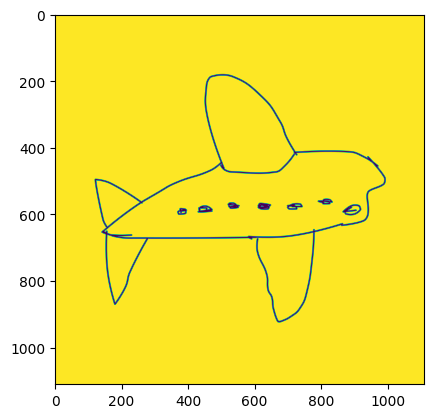

In [ ]:
list_transform = [
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.RandomResizedCrop(size=(224, 224), antialias=True)
]

transform = list_transform[2]

sketch_path = '/content/data_sketches/data_sketches/train_images/000_airplane/1.png'
sketch = Image.open(sketch_path)

transformed_sketch = transform(sketch)

plt.imshow(transformed_sketch)

Prepare training data

In [ ]:
image_data = datasets.ImageFolder('data_sketches/data_sketches/train_images')

train_data_path = [image_data.imgs[i][0] for i in tqdm(range(len(image_data)))]
train_labels = [image_data.imgs[i][1] for i in tqdm(range(len(image_data)))]

train_data_path, train_labels= shuffle(train_data_path, train_labels,  random_state=0, n_samples=len(train_data_path))
train_dataset = AugmentedCustomImageDataset(data_path=train_data_path, labels=train_labels, transform=data_transforms)
len(train_dataset)

100%|██████████| 12000/12000 [00:00<00:00, 1975106.86it/s]


12000

Prepare validation data

In [ ]:
image_data = datasets.ImageFolder('data_sketches/data_sketches/val_images')

images_classes = image_data.classes
val_data_path = [image_data.imgs[i][0] for i in tqdm(range(len(image_data)))]
val_labels = [image_data.imgs[i][1] for i in tqdm(range(len(image_data)))]

val_dataset = CustomImageDataset(data_path=val_data_path, labels=val_labels, transform=data_transforms)
len(val_dataset)

100%|██████████| 2250/2250 [00:00<00:00, 1493934.46it/s]


2250

### Merge training and validation data and train on all available data

In [12]:
image_data_train = datasets.ImageFolder('data_sketches/data_sketches/train_images')
image_data_val = datasets.ImageFolder('data_sketches/data_sketches/val_images')
images_classes = image_data_train.classes

train_data_path = [image_data_train.imgs[i][0] for i in tqdm(range(len(image_data_train)))]
train_labels = [image_data_train.imgs[i][1] for i in tqdm(range(len(image_data_train)))]

val_data_path = [image_data_val.imgs[i][0] for i in tqdm(range(len(image_data_val)))]
val_labels = [image_data_val.imgs[i][1] for i in tqdm(range(len(image_data_val)))]

train_all_path = train_data_path + val_data_path
train_all_labels = train_labels + val_labels

train_all_path, train_all_labels= shuffle(train_all_path, train_all_labels,  random_state=0, n_samples=len(train_all_path))

train_dataset = AugmentedCustomImageDataset(data_path=train_all_path, labels=train_all_labels, transform=data_transforms)
len(train_dataset)

100%|██████████| 2250/2250 [00:00<00:00, 1565817.82it/s]


14250

Define the acuuracy metric function

In [ ]:
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

Prepare the hugging face trainer: th following parameters change depend on the experiment

In [14]:
training_args = TrainingArguments(
  output_dir="./expert1",
  per_device_train_batch_size=64,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  logging_strategy="epoch",
  #eval_steps=94, # 4 eval per epoch
  warmup_ratio= 0.1,
  num_train_epochs=12,
  lr_scheduler_type='linear',
  fp16=True,
  #save_steps=94,#  save per epoch
  #logging_steps=22, # 4 logs per epoch
  learning_rate=1e-4,
  weight_decay=0.02,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
)

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

Start the training and enjoy the loss descreasing and the accuracy augmenting...

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


### Prediction on test data

Load the trained model checkpoint

In [31]:
model = ViTForImageClassification.from_pretrained("/content/expert1")
model = model.to(device)

Prepare the test data

In [32]:
image_data = datasets.ImageFolder('data_sketches/data_sketches/test_images')

test_data_path = [image_data.imgs[i][0] for i in tqdm(range(len(image_data)))]
test_labels = [image_data.imgs[i][1] for i in tqdm(range(len(image_data)))]

test_dataset = CustomImageDataset(data_path=test_data_path, labels=test_labels, transform=data_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 5750/5750 [00:00<00:00, 1151456.10it/s]


In [34]:
def predict_classes(model, loader):
  """
  Function to make predictions on test data
  """
  model.eval()

  all_predictions = []

  with torch.no_grad():

      for batch in tqdm(loader):
          inputs = batch["pixel_values"].to(device)

          outputs = model(inputs)
          predictions = torch.argmax(outputs.logits, dim=1)

          all_predictions.extend(predictions.cpu().numpy())

  return all_predictions

Predict the test data classes and save the predicted array

In [35]:
test_pred = predict_classes(model, test_dataloader)
np.save('test_pred_expert1.npy', test_pred)

100%|██████████| 90/90 [03:49<00:00,  2.55s/it]


Expert agregation

In [ ]:
def experts_agregator_n5(alls, experts_acc):

    """
    Function to agregate all predictions of the five experts to make one final predicition
    
    Args:
        alls: a numpy array of size (number of experts, number of test images)
        experts_acc: a list of accuracy of all experts
    """

    agreement_distrib = np.zeros((alls.shape[1]))
    for sample in range(alls.shape[1]):
        unique = np.unique(alls[:, sample], return_counts=True)[1].max()
        agreement_distrib[sample] = unique

    prediction = np.zeros((alls.shape[1],))
    for idx, unique in enumerate(agreement_distrib):
        if unique == 5:
            prediction[idx] = alls[0, idx]
        else:
            unique_preds = np.unique(alls[:, idx], return_counts=True)
            if unique == 1:
                prediction[idx] = alls[0, idx]
            elif unique in [3,4]:
                majority_class = unique_preds[0][unique_preds[1].argmax()]
                prediction[idx] = majority_class
            else:
                if len(unique_preds[0]) == 3:# vote [2,2,1]
                    ttc = np.argsort(-unique_preds[1])[0:2] #top_two_classes
                    acc_group0 = sum([experts_acc[i] for i in range(5) if alls[i, idx] == unique_preds[0][ttc[0]]])/2
                    acc_group1 = sum([experts_acc[i] for i in range(5) if alls[i, idx] == unique_preds[0][ttc[1]]])/2
                    if acc_group0 > acc_group1:
                        prediction[idx] = unique_preds[0][ttc[0]]
                    else:
                        prediction[idx] = unique_preds[0][ttc[1]]
                else: # vote [2,1,1,1]
                    majority_class = unique_preds[0][unique_preds[1].argmax()]
                    prediction[idx] = majority_class



    return agreement_distrib, prediction

def experts_agregator_n4(alls, experts_acc):
    """
    same function with four experts
    """

    agreement_distrib = np.zeros((alls.shape[1]))
    for sample in range(alls.shape[1]):
        unique = np.unique(alls[:, sample], return_counts=True)[1].max()
        agreement_distrib[sample] = unique

    prediction = np.zeros((alls.shape[1],))
    for idx, unique in enumerate(agreement_distrib):
        if unique == 4:
            prediction[idx] = alls[0, idx]
        else:
            unique_preds = np.unique(alls[:, idx], return_counts=True)
            if unique == 1:
                prediction[idx] = alls[0, idx]
            elif unique == 3:
                majority_class = unique_preds[0][unique_preds[1].argmax()]
                prediction[idx] = majority_class
            else:
                if len(unique_preds[0]) == 2: # vote [2,2]
                    acc_group0 = sum([experts_acc[i] for i in range(4) if alls[i, idx] == unique_preds[0][0]])/2
                    acc_group1 = sum([experts_acc[i] for i in range(4) if alls[i, idx] == unique_preds[0][1]])/2
                    if acc_group0 > acc_group1:
                        prediction[idx] = unique_preds[0][0]
                    else:
                        prediction[idx] = unique_preds[0][1]
                else: #vote [2,1, 1]
                    majority_class = unique_preds[0][unique_preds[1].argmax()]
                    prediction[idx] = majority_class

    return agreement_distrib, prediction

Experts agregation prediction

In [ ]:
experts_acc = [81.2889, 80.8444, 80.993, 79.426, 77.6]

# make sure you have the good path
alls = np.array([list(np.load(f'/content/test_pred_expert{i}.npy')) for i in range(1, 6)])

_, test_data_predictions = experts_agregator_n5(alls, experts_acc)

In [ ]:

kaggle_tab = pd.DataFrame([], columns=['Id', 'Label'])

kaggle_tab['Id'] = [i.split('/')[-1].split('.')[0] for i in test_data_path]
kaggle_tab['Category'] = test_data_predictions.astype(int)

kaggle_tab.head()

,Id,Category
0,0003b516ee21459bb961c473f00e513b.png,137.0
1,001962c430c843adb5f9548d50c10f06.png,112.0
2,001a7264820e4a6784e8b06cd05c531d.png,52.0
3,001a76fcb3a04957a54a3ec9e59c33db.png,62.0
4,0024f57a57c84c7cbef382ff841e0845.png,222.0


Save the test predictions file and submit it on kaggle, Ta daaa !!

In [ ]:
kaggle_tab.to_csv('kaggle_tab.csv', index=False)